### Multi-Document Summarization with Submodular Function Optimization

Reference: www.aclweb.org/anthology/N10-1134.pdf

**Introduction:**

Extractive summarization involves selecting representative sentences (or phrases/words) that summarize what the corpus is trying to convey. One way to model this problem is to consider the corpus as a set of sentences, and we want to pick a much smaller subset that has high overall similarity (semantically) to other sentences outside the subset. In addition, we want to penalize the chosen subset for redundancy, i.e. similarity within the subset.


$$f(S) = \sum_{i\notin S} \sum_{j\in S} sim_{i,j} - \lambda \sum_{i\in S} \sum_{j\in S, i\neq j} sim_{i,j}$$

$S$ is a subset of sentences, $sim_{i,j}$ is the similarity** between sentence $i$ and $j$, and $\lambda$ determines how much to penalize for redundancy. 

This function is submodular because both parts are submodular and submodularity is closed under addition. While finding the exact solution is NP-hard, the greedy (and much faster) method of adding the next best sentence to the subset works reasonably well as demonstrated in the reference paper.

\** The pairwise similarity $sim_{i,j}$ can be defined in many ways, e.g. norm of difference between vectorized sentences obtained using pre-train model or something simple like dot product of tf-idf vectors.

----

**Example: Product Review Summarization**

In the code below, I will use a greedy lazy algorithm on product review data for various products including GPS and hotel rooms. For each product, there is a list of reviews and the objective is to pick a representative subset of reviews. I decided to use TF-IDF vectorizer trained on a Time Magazine reviews corpus but something like word2vec is probably the way to go.

The algorithm is "lazy" because I used a maxheap to efficiently find the next best sentence to add to the set and avoid repeatedly finding the next best sentence to add. This massively improves computational efficiency.

[ROUGE-n](https://en.wikipedia.org/wiki/ROUGE_(metric)) is the standard evaluation metric for summarization tasks, but for demonstration purposes, a few sample outputs will be shown alongside a human curated subset and you can judge for yourself!

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, re, time
from nltk.corpus import brown
en_corpus = brown.words(fileids=['cc17'])

#### Load product review data

In [2]:
name = []
text = []
gold = []

for filename in os.listdir('topics'):
    dataname = filename.split('.')[0]
    name.append(dataname)
    f = open('topics\\' + filename)
    lines = f.readlines()
    lines = [re.sub('[^0-9a-zA-Z]+', ' ', line.lower()).strip() for line in lines]
    text.append(lines)
    
    summaries = []
    for summ_name in os.listdir('summaries-gold\\' + dataname):
        f = open('summaries-gold\\' + dataname + '\\' + summ_name)
        lines = f.readlines()
        lines = [re.sub('[^0-9a-zA-Z]+', ' ', line.lower()).strip() for line in lines]
        summaries.append(lines)
    gold.append(summaries)

#### Some sample reviews

In [3]:
for t, n in zip(text[1:3], name[1:3]):
    print('PRODUCT: ', n)
    print(t[:3])
    print()

PRODUCT:  bathroom_bestwestern_hotel_sfo
['the room was not overly big but clean and very comfortable beds a great shower and very clean bathrooms', 'the second room was smaller with a very inconvenient bathroom layout but at least it was quieter and we were able to sleep', 'large comfortable room wonderful bathroom']

PRODUCT:  battery-life_amazon_kindle
['after i plugged it in to my usb hub on my computer to charge the battery the charging cord design is very clever', 'after you have paged tru a 500 page book one page at a time to get from chapter 2 to chapter 15 see how excited you are about a low battery and all the time it took to get there', 'no user replaceable battery unless you buy the extended warranty for 65']



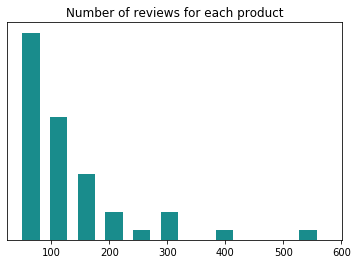

In [4]:
num_reviews = [len(x) for x in text]
sns.distplot(num_reviews, kde=False, hist_kws={'color':'teal', 'alpha':0.9, 'width':30})
plt.title('Number of reviews for each product');
plt.tick_params(axis='y',  which='both', left=False, labelleft=False);

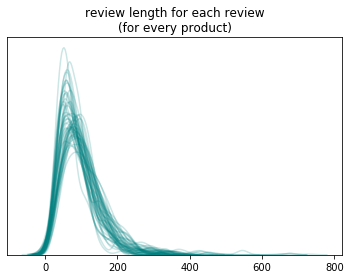

In [5]:
for t in text:
    review_len = [len(x) for x in t]
    sns.distplot(review_len, kde=True, hist=False, kde_kws={'alpha':0.2, 'color':'teal'})
plt.title('review length for each review\n(for every product)')
plt.tick_params(axis='y',  which='both', left=False, labelleft=False);

#### Sample Outputs

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer().fit(en_corpus)

In [15]:
import summarizer

for i in np.random.randint(0, len(text), size=10):
    print('PRODUCT: {} ({} reviews)'.format(name[i], len(text[i])))
    gold_budget = sum([len(g) for g in gold[i][0]])
    s = summarizer.Summarizer(text[i], vectorizer, budget=gold_budget*1.1)
    results = s.summarize()
    print('ALGORITHM:')
    [print('{}. {}'.format(i+1, r)) for i, r in enumerate(results)]
    print('HUMAN-CURATED:')
    [print('{}. {}'.format(i+1, r)) for i, r in enumerate(gold[i][0])]
    print('--------------------------------------')
    print()

PRODUCT: gas_mileage_toyota_camry_2007 (115 reviews)
took 0.1s.
ALGORITHM:
1. the engine ride and gas mileage is great
HUMAN-CURATED:
1. gas mileage is below what is expected
--------------------------------------

PRODUCT: sound_ipod_nano_8gb (101 reviews)
took 0.1s.
ALGORITHM:
1. and the sound and quality is great
2. the sound quality is good and
HUMAN-CURATED:
1. the sound quality is very good
2. you don t even need headphones
--------------------------------------

PRODUCT: battery-life_netbook_1005ha (333 reviews)
took 0.9s.
ALGORITHM:
1. the battery life is incredible
2. the battery life is incredible
3. 5 hour battery life is great
4. the battery life is amazing
HUMAN-CURATED:
1. the battery life is longer then 5 hours
2. but due to the battery charger this may decrease or not work at all
--------------------------------------

PRODUCT: size_asus_netbook_1005ha (86 reviews)
took 0.1s.
ALGORITHM:
1. my advice is to visit a store to personally try the keyboard and screen size
2. t